In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.steinhardt import *
from src.data import *
from src.plotting import *

plt.style.use('plot.mplstyle')

In [2]:
fausto_steinhardt, fausto_dens = process_water_structures('testing')
mda_steinhardt, mda_dens = process_mda_structures(all_runs=True)

In [3]:
all_faustos = np.vstack(list(fausto_steinhardt.values()))
all_mdas = np.vstack(list(mda_steinhardt.values()))
all_data = np.vstack((all_faustos, all_mdas))

In [4]:
mda_av_steinhardt = {}
mda_stds = {}
for struct_type, steinhardts in mda_steinhardt.items():
    mda_av_steinhardt[struct_type] = np.mean(steinhardts, axis=0)

In [5]:
AVG_MDA_STEINHARDT_VECTOR = mda_av_steinhardt['mda']

In [14]:
from ase.io import read

traj_type = 'compression'
temp = 140
run = 1

if traj_type == 'compression':
    pressures =np.arange(100, 20_001, 100)
elif traj_type == 'decompression':
    pressures =np.arange(-5000, 19_901, 100)


all_atom_descriptors = {}
"""a dict of pressure to a np array of shape (n_structures, n_atoms, n_descriptors)"""

for p in pressures:
    file_name = f"../data/trajectories_{temp}K_run{run}/{traj_type}/{traj_type}_pressure{p}.extxyz"
    structures = read(file_name, index=':')
    # get an average steinhardt descriptor
    descriptors = []
    for s in structures:
        descriptors.append(s.arrays["steinhardt_descriptor"])
    
    all_atom_descriptors[p] = np.array(descriptors)

In [15]:
from sklearn.preprocessing import StandardScaler

transform = StandardScaler()
"""
standardizes a steinhard vector, with per-feature mean and std
as calculated over all atoms from all structures in the 
de/compression trajectory
"""

all_descriptors = np.vstack(np.vstack(list(all_atom_descriptors.values())))
transform.fit(all_descriptors)
all_descriptors.shape

(1024000, 30)

5400

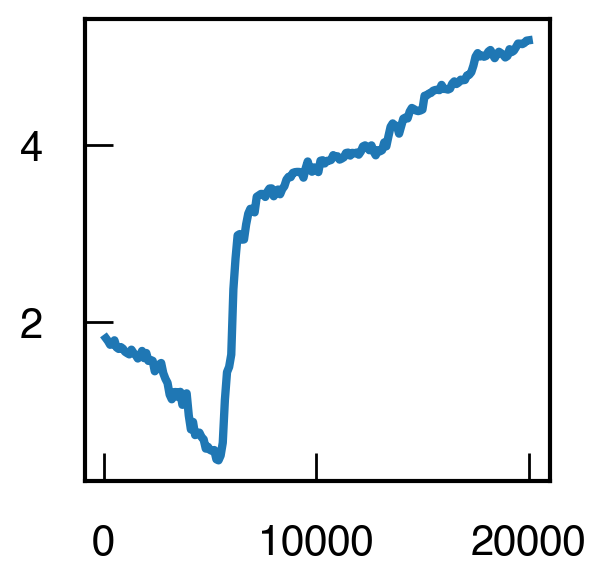

In [16]:
# find the pressure at which the structure is most similar to the mda structure
std_mda_vector = transform.transform(AVG_MDA_STEINHARDT_VECTOR.reshape(1, -1)).reshape(-1)

distances = []
for p, descriptors in all_atom_descriptors.items():
    # stack all the descriptors for this pressure
    stacked_descriptors = np.vstack(descriptors)
    # standardize
    standardized_descriptors = transform.transform(stacked_descriptors)
    
    # get the rmse between the average mda descriptor and the
    # average descriptor for this pressure
    per_atom_distance = np.linalg.norm(
        standardized_descriptors.mean(axis=0) - std_mda_vector,
    )
    
    # get the average distance between each atomic environment
    # and the average mda environment
    distances.append(per_atom_distance)

all_pressures = np.array(list(all_atom_descriptors.keys()))
most_similar_idx = np.argmin(distances)

plt.figure(figsize=(3, 3))
plt.plot(all_pressures, distances)

all_pressures[most_similar_idx]

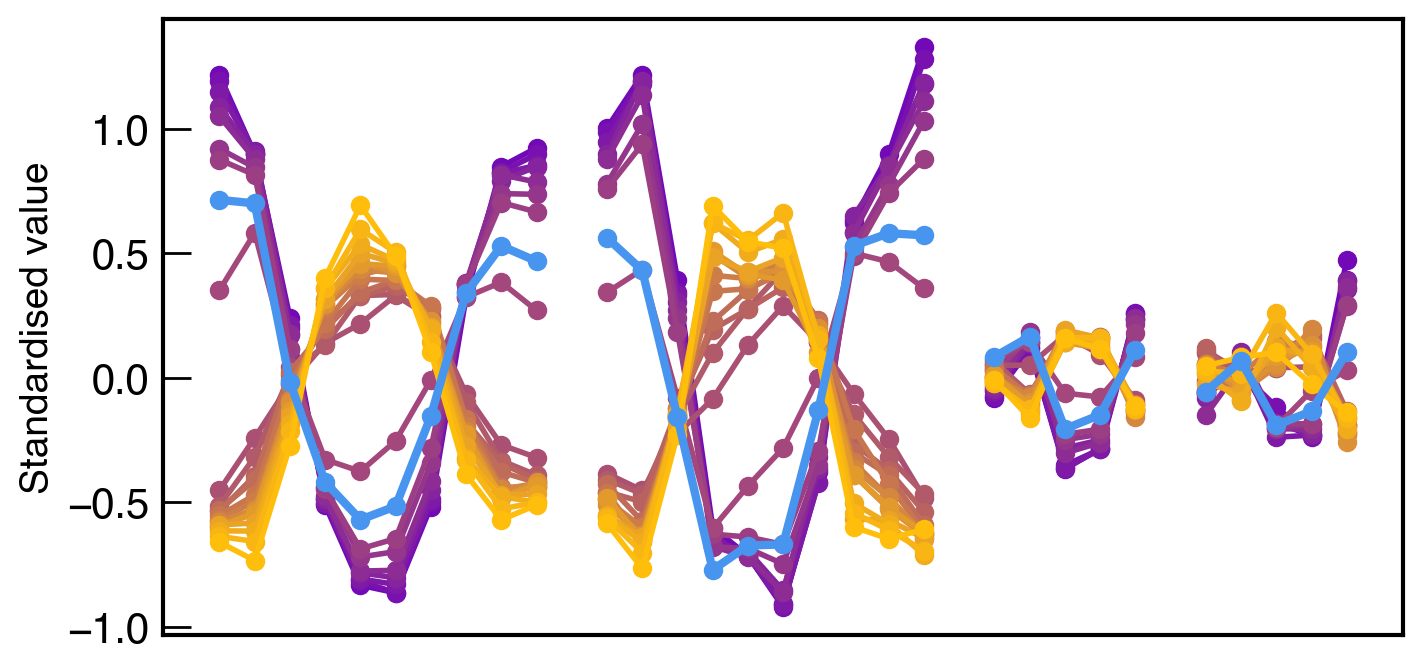

In [13]:
mda_color = '#4895ef'
hda_color = '#ffbe0b'
lda_color = '#7209b7'
pressure_colours = list(colour_gradient(all_pressures, lda_color, hda_color))

def plot_pressure(p):
    """which pressures should we plot?"""
    return p % 1000 == 0 or p == 100

# disconnect the plot at these points
start_stops = [(0, 10), (10, 20), (20, 25), (25, 30)]
spacing = 1

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for i, (pressure, colour) in enumerate(pressure_colours):
    if not plot_pressure(pressure):
        continue
    
    # get the average steinhardt descriptor for this pressure
    avg_steinhardt = np.mean(np.vstack(all_atom_descriptors[pressure]), axis=0)
    # standardize
    standardized_descriptors = transform.transform(avg_steinhardt.reshape(1, -1)).reshape(-1)
    
    for x, (start, stop) in enumerate(start_stops):
        ax.plot(
            np.arange(start + x*spacing, stop+x*spacing),
            standardized_descriptors[start:stop],
            "-o",
            color=colour,
            linewidth=2,
        )
        
    
# plot the mda structure
for x, (start, stop) in enumerate(start_stops):
    ax.plot(
        np.arange(start + x*spacing, stop+x*spacing),
        std_mda_vector[start:stop],
        "-o",
        color=mda_color,
        linewidth=3,
        markersize=6,
    )
    
ax.set_xticks([])
ax.set_ylabel('Standardised value',fontsize=14)
ax.tick_params(axis='y', which='major', pad=5);